# **Dataset Acquisition**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import sklearn
from sklearn import svm
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Convolutional Neural Network: Training**

In [ ]:
from torchvision.datasets import ImageFolder

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="/content/drive/My Drive/wikiart_5styles_2000", transform=data_transforms)

print(len(dataset))

train_num = int(len(dataset)*0.70) + 1
valid_num = int(len(dataset)*0.15)
test_num = int(len(dataset)*0.15)

print(train_num)
print(valid_num)
print(test_num)
print(train_num + valid_num + test_num)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_num, valid_num, test_num])

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on GPU!")
else:
    device = torch.device("cpu")
    print("Training on CPU!")

train_loader = torch.utils.data.DataLoader(train_set, 64, num_workers=0)
bum_ =[data for data in train_loader]
valid_loader = torch.utils.data.DataLoader(valid_set, 64, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, 64, num_workers=0)

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_set, 64, num_workers=0)
waste_time =[data for data in valid_loader]

# **Convolutional Neural Network: Performance Evaluation**

In [ ]:
import matplotlib.pyplot as plt
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate_network(network, loader):

  if torch.cuda.is_available():
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  network.to(device)

  loss_function = nn.CrossEntropyLoss()

  network_loss = 0.0
  network_accuracy = 0.0
  num_datapoints = 0

  for i, data in enumerate(loader, 0):
    x, y = data
    x = x.to(device)
    y = y.to(device)
    print(f'x: {x.shape}')
    y_hat = network(x)

    loss = loss_function(y_hat, y)
    predicted = torch.argmax(torch.softmax(y_hat, dim=1), 1)
    
    network_loss += loss.detach().item()
    network_accuracy += (predicted == y).sum().detach().item()
    num_datapoints += len(y)
  
  return network_loss/(i+1), network_accuracy/num_datapoints

def train_net(network, train_loader, valid_loader, learning_rate=0.01, weight_decay=0, num_epochs=30):

  if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on GPU!")
  else:
    device = torch.device("cpu")
    print("Training on CPU!")

  network.to(device)
      
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

  train_loss_per_epoch = []
  train_accuracy_per_epoch = []
  
  valid_loss_per_epoch = []
  valid_accuracy_per_epoch = []

  for epoch in range(num_epochs):
    print(epoch)

    network.train(True)

    for i, data in enumerate(train_loader, 0):
      x, y = data
      x = x.to(device)
      y = y.to(device)
      y_hat = network(x)

      loss = loss_function(y_hat, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    network.train(False)

    training_loss, training_accuracy = evaluate_network(network, train_loader)

    train_loss_per_epoch.append(training_loss)
    train_accuracy_per_epoch.append(training_accuracy)
    print(training_loss, training_accuracy)

    if (valid_loader is not None):
      valid_loss, valid_accuracy = evaluate_network(network, valid_loader)

      valid_loss_per_epoch.append(valid_loss)
      valid_accuracy_per_epoch.append(valid_accuracy)
      print(valid_loss, valid_accuracy)

  if (valid_loader is None):
    return train_loss_per_epoch, train_accuracy_per_epoch
  else:
    return train_loss_per_epoch, train_accuracy_per_epoch, valid_loss_per_epoch, valid_accuracy_per_epoch

def plot_training_curve(network, train_loss_per_epoch, train_acc_per_epoch, valid_loss_per_epoch=None, valid_acc_per_epoch=None):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

  fig.set_figheight(5)
  fig.set_figwidth(20)

  training_loss_only = "Training Loss for "
  training_and_validation_loss = "Training/Validation Loss for "

  training_acc_only = "Training Accuracy for "
  training_and_validation_acc = "Training/Validation Accuracy for "

  if (valid_loss_per_epoch is None or valid_acc_per_epoch is None):
    ax1.title.set_text(training_loss_only + network.name)
    ax1.plot(train_loss_per_epoch, color="blue", label="Training")
  else:
    ax1.title.set_text(training_and_validation_loss + network.name)
    ax1.plot(train_loss_per_epoch, color="blue", label="Training")
    ax1.plot(valid_loss_per_epoch, color="orange", label="Validation")
  ax1.legend()
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")

  if (valid_loss_per_epoch is None or valid_acc_per_epoch is None):
    ax2.title.set_text(training_acc_only + network.name)
    ax2.plot(train_acc_per_epoch, color="blue", label="Training")
  else:
    ax2.title.set_text(training_and_validation_acc + network.name)
    ax2.plot(train_acc_per_epoch, color="blue", label="Training")
    ax2.plot(valid_acc_per_epoch, color="orange", label="Validation")
  ax2.legend()
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")

  print("Final Training Loss/Accuracy for " + network.name + ":", train_loss_per_epoch[-1], "/", train_acc_per_epoch[-1])
  if (valid_loss_per_epoch is not None and valid_acc_per_epoch is not None):
    print("Final Validation Loss/Accuracy for " + network.name + ":", valid_loss_per_epoch[-1], "/", valid_acc_per_epoch[-1])
  
  return 

In [ ]:
evaluate_network(network, loader)

In [ ]:
import torchvision.models as models
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch, gc

gc.collect()
torch.cuda.empty_cache()

resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features

resnet_model.fc = nn.Linear(num_ftrs, 5)

[train_loss, train_acc, valid_loss, valid_acc] = train_net(resnet_model, train_array, valid_array, learning_rate=0.000005, weight_decay=0.007, num_epochs=15)

Training on GPU!
0
1.269073602286252 0.4886444793600914
1.317353516817093 0.44466666666666665
1
1.0610461793162607 0.5984859305813455
1.1408998693029087 0.5386666666666666
2
0.9361093418164687 0.6580488501642623
1.0466521630684535 0.5806666666666667
3
0.8474360780282454 0.696186259105842
0.9897677550713221 0.596
4
0.7761197339404713 0.7256106270532781
0.9518285691738129 0.6133333333333333
5
0.7144909777424552 0.7500357091844022
0.9252393394708633 0.6266666666666667
6
0.6584922655062242 0.7741751178403086
0.9057521770397822 0.632
7
0.6064400361342863 0.8010284245107842
0.8914341628551483 0.6353333333333333
8
0.5572494872591712 0.822739608627339
0.8810903156797091 0.642
9
0.5104040928862311 0.8414512212541065
0.8741180797417959 0.648
10
0.46585600836710495 0.8630195686330524
0.8699218854308128 0.6473333333333333
11
0.42329961088570683 0.8830167118983002
0.8680055638154348 0.6513333333333333
12
0.3828473898497495 0.9020139980002857
0.8682096004486084 0.656
13
0.34479447156190873 0.9201542

Final Training Loss/Accuracy for Resnet: 0.3091341724449938 / 0.9331524067990287
Final Validation Loss/Accuracy for Resnet: 0.8742045213778814 / 0.6573333333333333


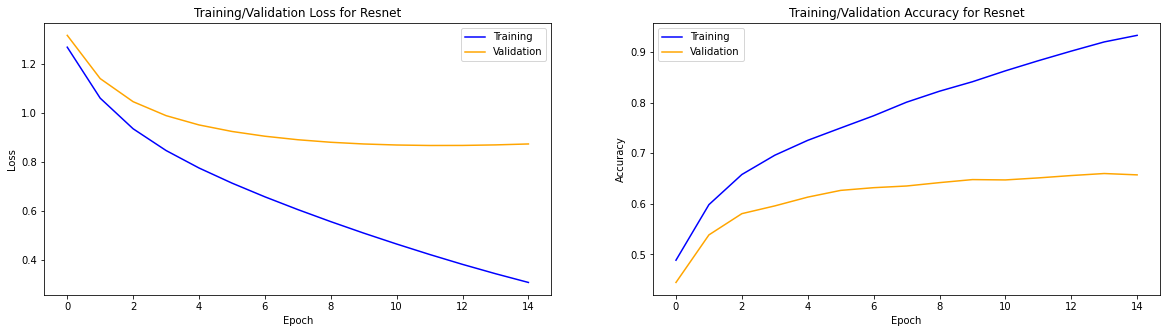

In [ ]:
resnet_model.name = "Resnet"
torch.save(resnet_model.state_dict(), '/content/drive/My Drive/models/resnetmodel_state')
plot_training_curve(resnet_model, train_loss, train_acc, valid_loss, valid_acc)

In [ ]:
def confusion_matrix(model, dataloader, dataset,input_type="Training"):

  image, labeler = [],[]
  label_loss = [0]*len(dataset.classes)
  network_accuracy = [0]*len(dataset.classes)
  num_datapoints = [0]*len(dataset.classes)

  for i, data in enumerate(dataloader, 0):
      x, y = data
      x=x.cuda()
      y=y.cuda()
      #image.append(x.flatten().tolist())
      labeler.append(dataset.classes[y.item()])
      y_hat = model(x)
      #loss = loss_function(y_hat, y)
      predicted = torch.argmax(torch.softmax(y_hat, dim=1), 1)
      image.append(dataset.classes[predicted.item()])
      #network_loss[y] += loss.detach().item()
      network_accuracy[y] += (predicted == y).sum().detach().item()
      num_datapoints[y] += y
      
    

  predict = []


  for net,datapoints in zip(network_accuracy,num_datapoints):
    if datapoints != 0:
      predict.append(net/datapoints)

  labels_set = set(labeler)


  confusion_matrix = np.zeros((len(labels_set), len(labels_set)))

  label_dict = {label:index for (index, label) in enumerate(labels_set, 0)}


  #print(label_dict)
  for img, label in zip(image, labeler):
      #print(img)
      #print(label)
      confusion_matrix[label_dict[img]][label_dict[label]] += 1

  recalls = {}
  precisions = {}
  f1_scores = {}

  for label in labels_set:
    recalls[label] = (confusion_matrix[label_dict[label]][label_dict[label]])/(np.sum(confusion_matrix, axis=0)[label_dict[label]])
    precisions[label] = (confusion_matrix[label_dict[label]][label_dict[label]])/(np.sum(confusion_matrix, axis=1)[label_dict[label]])
    f1_scores[label] = 2*(precisions[label]*recalls[label])/(precisions[label] + recalls[label])
 

  scores = np.array([list(recalls.values()), list(precisions.values()), list(f1_scores.values())])

  actual_labels = ["actual_" + label for label in labels_set]
  predicted_labels = ["predicted_" + label for label in labels_set]

  confusion_matrix_df = pd.DataFrame(confusion_matrix, predicted_labels, actual_labels)

  scores_df = pd.DataFrame(scores, ["Recall", "Precision", "F1-Score"], labels_set)
  
  print("Confusion Matrix -- " + input_type + ":")
  display(confusion_matrix_df)

  print("\nClass Metric Scores -- " + input_type + ":")
  display(scores_df)

  #print("\nMicro F1-Score -- " + input_type + ":", round(np.sum(predicted == labeler)/len(labeler), 2))  
  #print("Macro F1-Score -- " + input_type + ":", round(sum(f1_scores.values())/(len(labels_set)), 2))
  print("Weighted F1-Score -- " + input_type + ":", round(np.sum((list(f1_scores.values()) * np.sum(confusion_matrix, axis=0))/np.sum(confusion_matrix)), 2))

  return label_dict
  

In [ ]:
transformers = transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()
        ])

label_dict ={}

#label_dict = confusion_matrix(resnet_model,valid_loader)

image = ImageFolder(root="/content/drive/My Drive/demo material", transform=transformers)

loader = torch.utils.data.DataLoader(image, 1, num_workers=0)

#print(image)
#print(loader)

img = image.__getitem__(0)
#print(img)


In [ ]:
def predict(network, loader,inv_map):

  if torch.cuda.is_available():
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  network.to(device)

  loss_function = nn.CrossEntropyLoss()

  network_loss = 0.0
  network_accuracy = 0.0
  num_datapoints = 0

  for i, data in enumerate(loader, 0):
    x, y = data
    x = x.to(device)
    y = y.to(device)
    y_hat = network(x)

    predicted = torch.argmax(torch.softmax(y_hat, dim=1), 1)   
    #network_accuracy += (predicted == y).sum().detach().item()
    #num_datapoints += len(y)
    
    print("predicted:",inv_map[predicted.item()],"actual:",inv_map[y.item()])


  return 

In [ ]:
f = [data for data in loader]

inv_map = {v: k for k, v in image.class_to_idx.items()}

predict(resnet_model,f, inv_map)




predicted: Cubism_2000 actual: Cubism_2000
predicted: Expressionism_2000 actual: Expressionism_2000
predicted: Symbolism_2000 actual: Impressionism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Symbolism_2000 actual: Symbolism_2000


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class ArtConv(nn.Module):
  def __init__(self, conv_filters=(100, 75, 50, 25), conv_dropout=(0.1, 0.2, 0.3), fc_units=(100, 50, 25), fc_dropout=0.3, output_classes=5):
    super(ArtConv, self).__init__()
    
    self.name = "ArtConv" + str(output_classes)

    self.conv_filters = conv_filters
    self.conv_dropout = conv_dropout
    self.fc_units = fc_units
    self.fc_dropout = fc_dropout
    self.output_classes = output_classes

    self.pool = nn.MaxPool2d(2, 2)

    self.cn1 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, self.conv_filters[0], 3),
        nn.BatchNorm2d(self.conv_filters[0]),
    )

    self.cn_a1 = nn.Sequential(
        nn.ReLU(),
        nn.Dropout2d(self.conv_dropout[0])
    )

    self.cn2 = nn.Sequential(
        nn.Conv2d(self.conv_filters[0], self.conv_filters[1], 3),
        nn.BatchNorm2d(self.conv_filters[1]),
    )

    self.cn_a2 = nn.Sequential(
        nn.ReLU(),
        nn.Dropout2d(self.conv_dropout[1])
    )

    self.cn3 = nn.Sequential(
        nn.Conv2d(self.conv_filters[1], self.conv_filters[2], 3),
        nn.BatchNorm2d(self.conv_filters[2]),
    )

    self.cn_a3 = nn.Sequential(
        nn.ReLU(),
        nn.Dropout2d(self.conv_dropout[2])
    )

    self.cn4 = nn.Sequential(
        nn.Conv2d(self.conv_filters[2], self.conv_filters[3], 3),
        nn.BatchNorm2d(self.conv_filters[3]),
    )

    self.cn_a4 = nn.Sequential(
        nn.ReLU()
    )

    self.fc1 = nn.Sequential(
        nn.Linear(self.conv_filters[3]*6*6, self.fc_units[0]),
        nn.ReLU(),
        nn.Dropout(self.fc_dropout)
    )

    self.fc2 = nn.Sequential(
        nn.Linear(self.fc_units[0], self.fc_units[1]),
        nn.ReLU(),
        nn.Dropout(self.fc_dropout)
    )

    self.fc3 = nn.Sequential(
        nn.Linear(self.fc_units[1], self.fc_units[2]),
        nn.ReLU(),
        nn.Dropout(self.fc_dropout)
    )

    self.fc4 = nn.Sequential(
        nn.Linear(self.fc_units[2], self.output_classes)
    )

  def forward(self, x):
    c_a1 = self.pool(self.cn_a1(self.cn1(x)))
    c_a2 = self.pool(self.cn_a2(self.cn2(c_a1)) + self.cn2(c_a1))
    c_a3 = self.pool(self.cn_a3(self.cn3(c_a2)))
    c_a4 = self.pool(self.cn_a4(self.cn4(c_a3)) + self.cn4(c_a3))
    f_a1 = self.fc1(c_a4.view(-1, self.conv_filters[3]*6*6))
    f_a2 = self.fc2(f_a1)
    f_a3 = self.fc3(f_a2)
    f_a4 = self.fc4(f_a3)
    return f_a4

In [ ]:
transformers = transforms.Compose([
        transforms.Resize((128,128)),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()
        ])

image = ImageFolder(root="/content/drive/My Drive/demo material", transform=transformers)

loader = torch.utils.data.DataLoader(image, 1, num_workers=0)

#print(image)
#print(loader)

img = image.__getitem__(0)

cnn = ArtConv(conv_dropout=(0, 0, 0), fc_dropout=0, output_classes=5)
cnn.load_state_dict(torch.load("/content/drive/My Drive/models/ArtConv5_2"))
predict(cnn,loader,inv_map)

test_loader = torch.utils.data.DataLoader(test_set, 1, num_workers=0)

confusion_matrix(cnn, test_loader, image,input_type="Training")

predicted: Romanticism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Expressionism_2000
predicted: Symbolism_2000 actual: Impressionism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Impressionism_2000 actual: Symbolism_2000


ValueError: ignored

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize((128,128)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="/content/drive/My Drive/wikiart_5styles_2000", transform=data_transforms)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_num, valid_num, test_num])


valid_loader = torch.utils.data.DataLoader(valid_set, 1, num_workers=0)
#valid_array =[data for data in valid_loader]

In [ ]:
predict(cnn,f,inv_map)

predicted: Romanticism_2000 actual: Impressionism_2000
predicted: Impressionism_2000 actual: Romanticism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Impressionism_2000 actual: Impressionism_2000
predicted: Impressionism_2000 actual: Impressionism_2000
predicted: Impressionism_2000 actual: Romanticism_2000
predicted: Impressionism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Romanticism_2000
predicted: Impressionism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Romanticism_2000
predicted: Romanticism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Impressionism_2000
predicted: Impressionism_2000 actual: Symbolism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Romanticism_2000 actual: Cubism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Symbolism_2000 actual: Symbolism_20

In [ ]:
dataset5 = ImageFolder(root="/content/drive/My Drive/wikiart_5styles_2000", transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()]))

print(len(dataset5))

train_num5 = round(len(dataset5)*0.70)
valid_num5 = round(len(dataset5)*0.15)
test_num5 = round(len(dataset5)*0.15)

print(train_num5)
print(valid_num5)
print(test_num5)
print(train_num5 + valid_num5 + test_num5)

train_set5, valid_set5, test_set5 = torch.utils.data.random_split(dataset5, [train_num5, valid_num5, test_num5])

train_loader5 = torch.utils.data.DataLoader(train_set5, 1, num_workers=0)
valid_loader5 = torch.utils.data.DataLoader(valid_set5, 1, num_workers=0)
test_loader5 = torch.utils.data.DataLoader(test_set5, 1, num_workers=0)


10001
7001
1500
1500
10001


In [ ]:
art_style_net5_demo = ArtConv(conv_dropout=(0, 0, 0), fc_dropout=0, output_classes=5)
art_style_net5_demo.train(False)
art_style_net5_demo.load_state_dict(torch.load("/content/drive/MyDrive/models/ArtConv5_2"))
art_style_net5_demo.to(torch.device("cuda"))

demo_dataset = ImageFolder(root="/content/drive/My Drive/demo material", transform=transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()]))

demo_loader = torch.utils.data.DataLoader(demo_dataset, 1, pin_memory=True, num_workers=2)

demo_data = []

for i in demo_loader:
  demo_data.append(i)

print(evaluate_network(art_style_net5_demo, demo_data))
confusion_matrix(art_style_net5_demo, demo_data, demo_dataset)


(1.3272518515586853, 0.4)
Confusion Matrix -- Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


,actual_Impressionism_2000,actual_Romanticism_2000,actual_Cubism_2000,actual_Expressionism_2000,actual_Symbolism_2000
predicted_Impressionism_2000,0.0,0.0,0.0,1.0,0.0
predicted_Romanticism_2000,0.0,1.0,0.0,0.0,0.0
predicted_Cubism_2000,0.0,0.0,1.0,0.0,1.0
predicted_Expressionism_2000,1.0,0.0,0.0,0.0,0.0
predicted_Symbolism_2000,0.0,0.0,0.0,0.0,0.0



Class Metric Scores -- Training:


,Impressionism_2000,Romanticism_2000,Cubism_2000,Expressionism_2000,Symbolism_2000
Recall,0.0,1.0,1.000000,0.0,0.0
Precision,0.0,1.0,0.500000,0.0,NaN
F1-Score,NaN,1.0,0.666667,NaN,NaN


Weighted F1-Score -- Training: nan


{'Cubism_2000': 2,
 'Expressionism_2000': 3,
 'Impressionism_2000': 0,
 'Romanticism_2000': 1,
 'Symbolism_2000': 4}

In [ ]:
dataset5 = ImageFolder(root="/content/drive/My Drive/wikiart_5styles_2000", transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()]))

print(len(dataset5))

train_num5 = round(len(dataset5)*0.70)
valid_num5 = round(len(dataset5)*0.15)
test_num5 = round(len(dataset5)*0.15)

print(train_num5)
print(valid_num5)
print(test_num5)
print(train_num5 + valid_num5 + test_num5)

train_set5, valid_set5, test_set5 = torch.utils.data.random_split(dataset5, [train_num5, valid_num5, test_num5])

train_loader5 = torch.utils.data.DataLoader(train_set5, 1, num_workers=0)
valid_loader5 = torch.utils.data.DataLoader(valid_set5, 1, num_workers=0)
test_loader5 = torch.utils.data.DataLoader(test_set5, 1, num_workers=0)


art_style_net5_demo = ArtConv(conv_dropout=(0, 0, 0), fc_dropout=0, output_classes=5)
art_style_net5_demo.train(False)
art_style_net5_demo.load_state_dict(torch.load("/content/drive/MyDrive/models/ArtConv5_2"))
art_style_net5_demo.to(torch.device("cuda"))

demo_dataset = ImageFolder(root="/content/drive/My Drive/demo material", transform=transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()]))

demo_loader = torch.utils.data.DataLoader(demo_dataset, 1, pin_memory=True, num_workers=0)

demo_data = []

for i in demo_loader:
  demo_data.append(i)


confusion_matrix(art_style_net5_demo, demo_data, demo_dataset)
predict(art_style_net5_demo,demo_data, inv_map)

10001
7001
1500
1500
10001
Confusion Matrix -- Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


,actual_Impressionism_2000,actual_Romanticism_2000,actual_Cubism_2000,actual_Expressionism_2000,actual_Symbolism_2000
predicted_Impressionism_2000,0.0,0.0,0.0,1.0,0.0
predicted_Romanticism_2000,0.0,1.0,0.0,0.0,0.0
predicted_Cubism_2000,0.0,0.0,1.0,0.0,1.0
predicted_Expressionism_2000,1.0,0.0,0.0,0.0,0.0
predicted_Symbolism_2000,0.0,0.0,0.0,0.0,0.0



Class Metric Scores -- Training:


,Impressionism_2000,Romanticism_2000,Cubism_2000,Expressionism_2000,Symbolism_2000
Recall,0.0,1.0,1.000000,0.0,0.0
Precision,0.0,1.0,0.500000,0.0,NaN
F1-Score,NaN,1.0,0.666667,NaN,NaN


Weighted F1-Score -- Training: nan
predicted: Cubism_2000 actual: Cubism_2000
predicted: Impressionism_2000 actual: Expressionism_2000
predicted: Expressionism_2000 actual: Impressionism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Cubism_2000 actual: Symbolism_2000


In [ ]:
transformers = transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()
        ])

label_dict ={}

#label_dict = confusion_matrix(resnet_model,valid_loader)

image = ImageFolder(root="/content/drive/My Drive/demo material", transform=transformers)

loader = torch.utils.data.DataLoader(image, 1, num_workers=0)

#print(image)
#print(loader)

img = image.__getitem__(0)
#print(img)

f = [data for data in loader]

inv_map = {v: k for k, v in image.class_to_idx.items()}

predict(resnet_model,f, inv_map)
confusion_matrix(resnet_model,f,demo_dataset)


predicted: Cubism_2000 actual: Cubism_2000
predicted: Expressionism_2000 actual: Expressionism_2000
predicted: Symbolism_2000 actual: Impressionism_2000
predicted: Romanticism_2000 actual: Romanticism_2000
predicted: Symbolism_2000 actual: Symbolism_2000
Confusion Matrix -- Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


,actual_Impressionism_2000,actual_Romanticism_2000,actual_Cubism_2000,actual_Expressionism_2000,actual_Symbolism_2000
predicted_Impressionism_2000,0.0,0.0,0.0,0.0,0.0
predicted_Romanticism_2000,0.0,1.0,0.0,0.0,0.0
predicted_Cubism_2000,0.0,0.0,1.0,0.0,0.0
predicted_Expressionism_2000,0.0,0.0,0.0,1.0,0.0
predicted_Symbolism_2000,1.0,0.0,0.0,0.0,1.0



Class Metric Scores -- Training:


,Impressionism_2000,Romanticism_2000,Cubism_2000,Expressionism_2000,Symbolism_2000
Recall,0.0,1.0,1.0,1.0,1.000000
Precision,NaN,1.0,1.0,1.0,0.500000
F1-Score,NaN,1.0,1.0,1.0,0.666667


Weighted F1-Score -- Training: nan


{'Cubism_2000': 2,
 'Expressionism_2000': 3,
 'Impressionism_2000': 0,
 'Romanticism_2000': 1,
 'Symbolism_2000': 4}